## DSWA + VISAGIO

importação de bibliotecas

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Bibliotecas importadas com sucesso")

Bibliotecas importadas com sucesso


leitura de arquivos

In [7]:
df_train = pd.read_csv('data/train.csv')
df_test =  pd.read_csv('data/test.csv')
df_produto = pd.read_csv('data/produto.csv')

print(f"Dados de treino: {df_train.shape[0]} linhas e {df_train.shape[1]} colunas")
print(f"Dados de teste: {df_test.shape[0]} linhas e {df_test.shape[1]} colunas")
print(f"Dados de produto: {df_produto.shape[0]} linhas e {df_produto.shape[1]} colunas")
print("\nDados carregados com sucesso")

Dados de treino: 27579 linhas e 9 colunas
Dados de teste: 2753 linhas e 6 colunas
Dados de produto: 6500 linhas e 4 colunas

Dados carregados com sucesso


análise exploratória

In [8]:
print(f"Linhas no Treino antes do merge: {df_train.shape[0]}")

df_produto['SKU'] = pd.to_numeric(df_produto['SKU'], errors='coerce')

df_completo = pd.merge(
    df_train,
    df_produto,
    left_on='sku',   # Nome da coluna na tabela da esquerda (vendas)
    right_on='SKU',  # Nome da coluna na tabela da direita (cadastro)
    how='left'
)

df_completo.drop('SKU', axis=1, inplace=True)

df_completo['data'] = pd.to_datetime(df_completo['data'])

df_completo['dia'] = df_completo['data'].dt.day
df_completo['mes'] = df_completo['data'].dt.month
df_completo['ano'] = df_completo['data'].dt.year
df_completo['dia_semana'] = df_completo['data'].dt.dayofweek  # 0=Segunda, 6=Domingo
df_completo['semana_do_ano'] = df_completo['data'].dt.isocalendar().week.astype(int)

df_completo['is_fim_de_semana'] = df_completo['dia_semana'].isin([5, 6]).astype(int)

print(f"Linhas no Treino pós-merge: {df_completo.shape[0]}")
print("\nVerificando se ficou algum valor nulo nas colunas novas (NOME, CATEGORIA...):")
print(df_completo[['NOME_PRODUTO', 'CATEGORIA']].isnull().sum())

print("\nAs primeiras 5 linhas do Dataset Mestre:")
display(df_completo.head())

print("\nTipos de dados corrigidos:")
df_completo.info()

Linhas no Treino antes do merge: 27579
Linhas no Treino pós-merge: 27579

Verificando se ficou algum valor nulo nas colunas novas (NOME, CATEGORIA...):
NOME_PRODUTO    0
CATEGORIA       0
dtype: int64

As primeiras 5 linhas do Dataset Mestre:


,data,sku,cod_filial,filial,unidade,demanda,faturamento,num_transacoes,clientes_unicos,NOME_PRODUTO,CATEGORIA,SUBCATEGORIA,dia,mes,ano,dia_semana,semana_do_ano,is_fim_de_semana
0,2024-01-02,9,101032,RUA,KG,0.430,30.12,3,3,CAST DE CAJU W4TS TOR C/SAL LUXO KG ...,Castanhas & Oleaginosas,Castanhas de Caju,2,1,2024,1,1,0
1,2024-01-03,9,101032,RUA,KG,0.238,16.65,2,2,CAST DE CAJU W4TS TOR C/SAL LUXO KG ...,Castanhas & Oleaginosas,Castanhas de Caju,3,1,2024,2,1,0
2,2024-01-04,9,101032,RUA,KG,0.400,27.97,2,2,CAST DE CAJU W4TS TOR C/SAL LUXO KG ...,Castanhas & Oleaginosas,Castanhas de Caju,4,1,2024,3,1,0
3,2024-01-05,9,101032,RUA,KG,0.378,26.45,2,2,CAST DE CAJU W4TS TOR C/SAL LUXO KG ...,Castanhas & Oleaginosas,Castanhas de Caju,5,1,2024,4,1,0
4,2024-01-06,9,101032,RUA,KG,0.766,53.58,4,4,CAST DE CAJU W4TS TOR C/SAL LUXO KG ...,Castanhas & Oleaginosas,Castanhas de Caju,6,1,2024,5,1,1



Tipos de dados corrigidos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27579 entries, 0 to 27578
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   data              27579 non-null  datetime64[ns]
 1   sku               27579 non-null  int64         
 2   cod_filial        27579 non-null  int64         
 3   filial            27579 non-null  object        
 4   unidade           27579 non-null  object        
 5   demanda           27579 non-null  float64       
 6   faturamento       27579 non-null  float64       
 7   num_transacoes    27579 non-null  int64         
 8   clientes_unicos   27579 non-null  int64         
 9   NOME_PRODUTO      27579 non-null  object        
 10  CATEGORIA         27579 non-null  object        
 11  SUBCATEGORIA      27579 non-null  object        
 12  dia               27579 non-null  int32         
 13  mes               27579 non-null  int32         

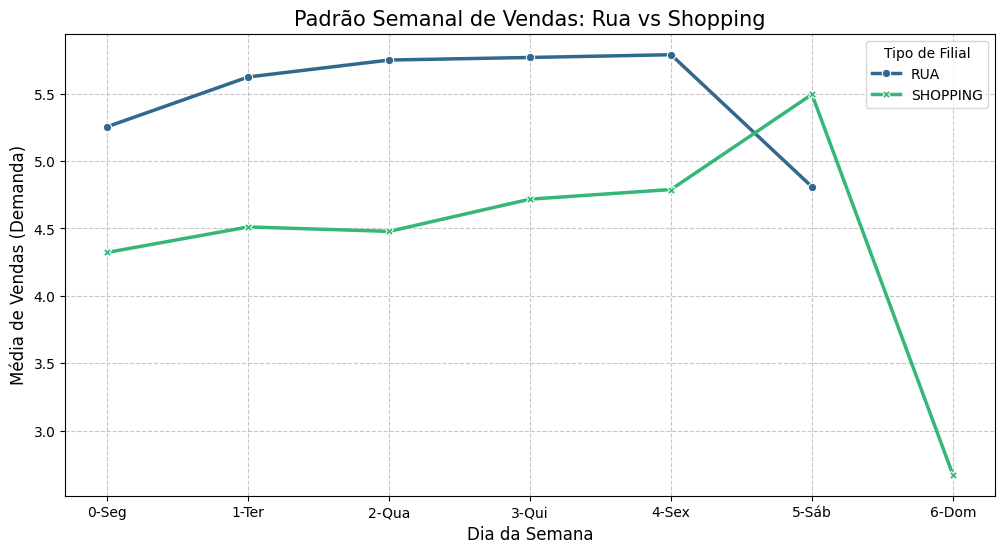

In [9]:
sazonalidade_semanal = df_completo.groupby(['dia_semana', 'filial'])['demanda'].mean().reset_index()

dias_map = {
    0: '0-Seg', 1: '1-Ter', 2: '2-Qua', 3: '3-Qui',
    4: '4-Sex', 5: '5-Sáb', 6: '6-Dom'
}
sazonalidade_semanal['nome_dia'] = sazonalidade_semanal['dia_semana'].map(dias_map)

# 3. Plotando o Gráfico
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=sazonalidade_semanal,
    x='nome_dia',
    y='demanda',
    hue='filial',       # Linhas diferentes para cada tipo de filial
    style='filial',     # Estilos diferentes (tracejado/sólido) para facilitar leitura
    markers=True,
    dashes=False,
    linewidth=2.5,
    palette='viridis'   # Cores contrastantes
)

plt.title('Padrão Semanal de Vendas: Rua vs Shopping', fontsize=15)
plt.xlabel('Dia da Semana', fontsize=12)
plt.ylabel('Média de Vendas (Demanda)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Tipo de Filial')
plt.show()

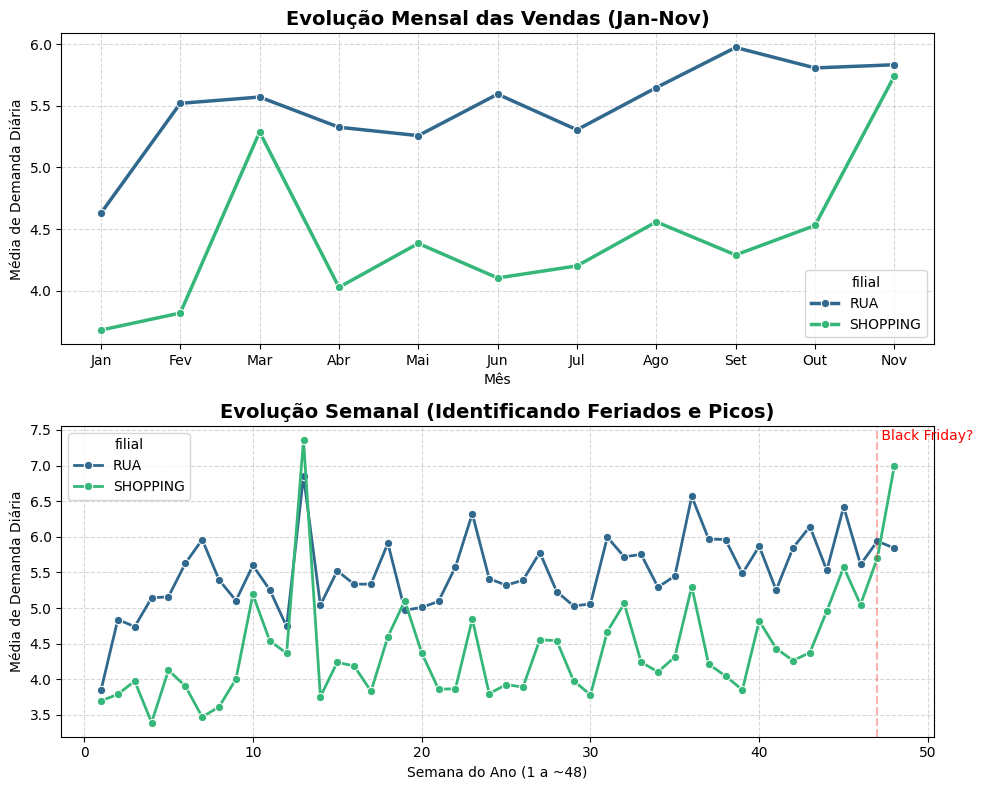

In [11]:
analise_mensal = df_completo.groupby(['mes', 'filial'])['demanda'].mean().reset_index()

analise_semanal = df_completo.groupby(['semana_do_ano', 'filial'])['demanda'].mean().reset_index()

mapa_meses = {
    1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'
}
analise_mensal['nome_mes'] = analise_mensal['mes'].map(mapa_meses)

fig, ax = plt.subplots(2, 1, figsize=(10, 8)) # Cria 2 gráficos (um em cima do outro)

sns.lineplot(
    data=analise_mensal,
    x='nome_mes',
    y='demanda',
    hue='filial',
    marker='o',
    linewidth=2.5,
    palette='viridis',
    ax=ax[0] # Desenha no primeiro espaço
)
ax[0].set_title('Evolução Mensal das Vendas (Jan-Nov)', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Média de Demanda Diária')
ax[0].set_xlabel('Mês')
ax[0].grid(True, linestyle='--', alpha=0.5)

# GRÁFICO 2: Visão Semanal (Detalhe Fino)
sns.lineplot(
    data=analise_semanal,
    x='semana_do_ano',
    y='demanda',
    hue='filial',
    marker='o',
    linewidth=2,
    palette='viridis',
    ax=ax[1] # Desenha no segundo espaço embaixo
)
ax[1].set_title('Evolução Semanal (Identificando Feriados e Picos)', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Média de Demanda Diária')
ax[1].set_xlabel('Semana do Ano (1 a ~48)')
ax[1].grid(True, linestyle='--', alpha=0.5)

plt.axvline(x=47, color='red', linestyle='--', alpha=0.3)
plt.text(47, analise_semanal['demanda'].max(), ' Black Friday?', color='red', fontsize=10)

plt.tight_layout()
plt.show()

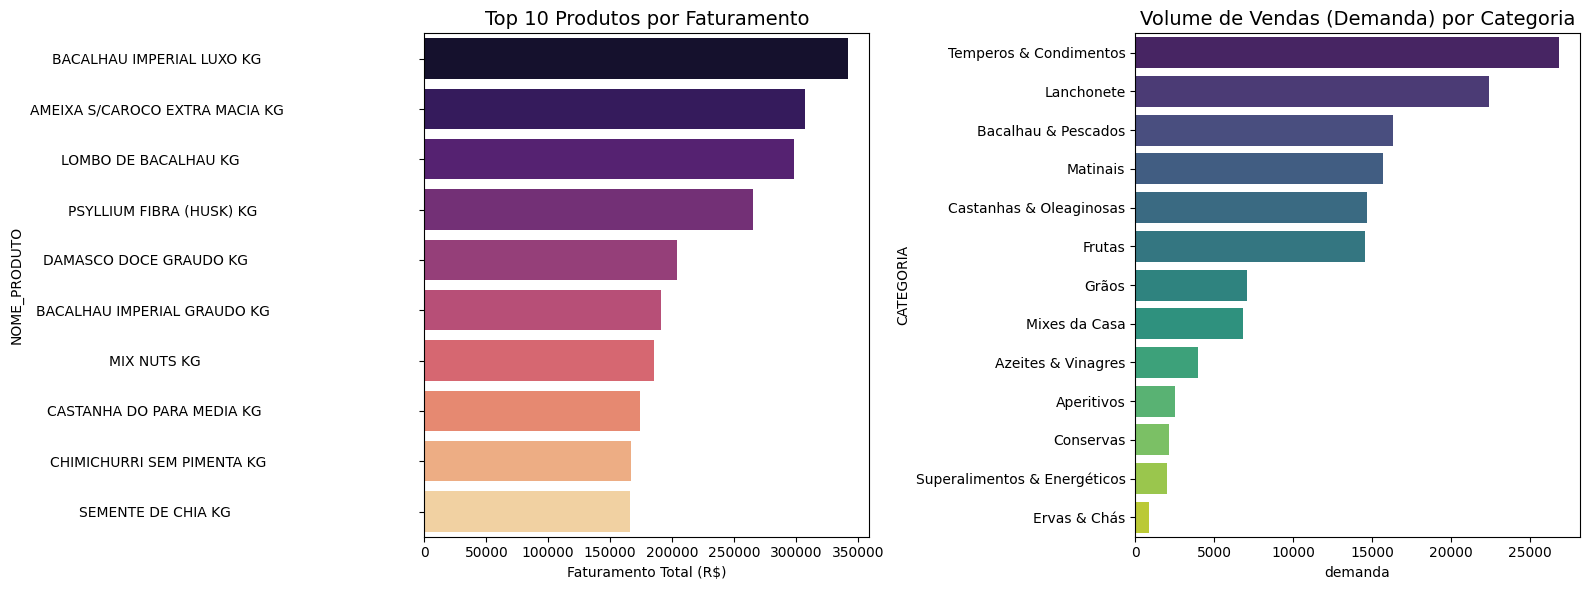

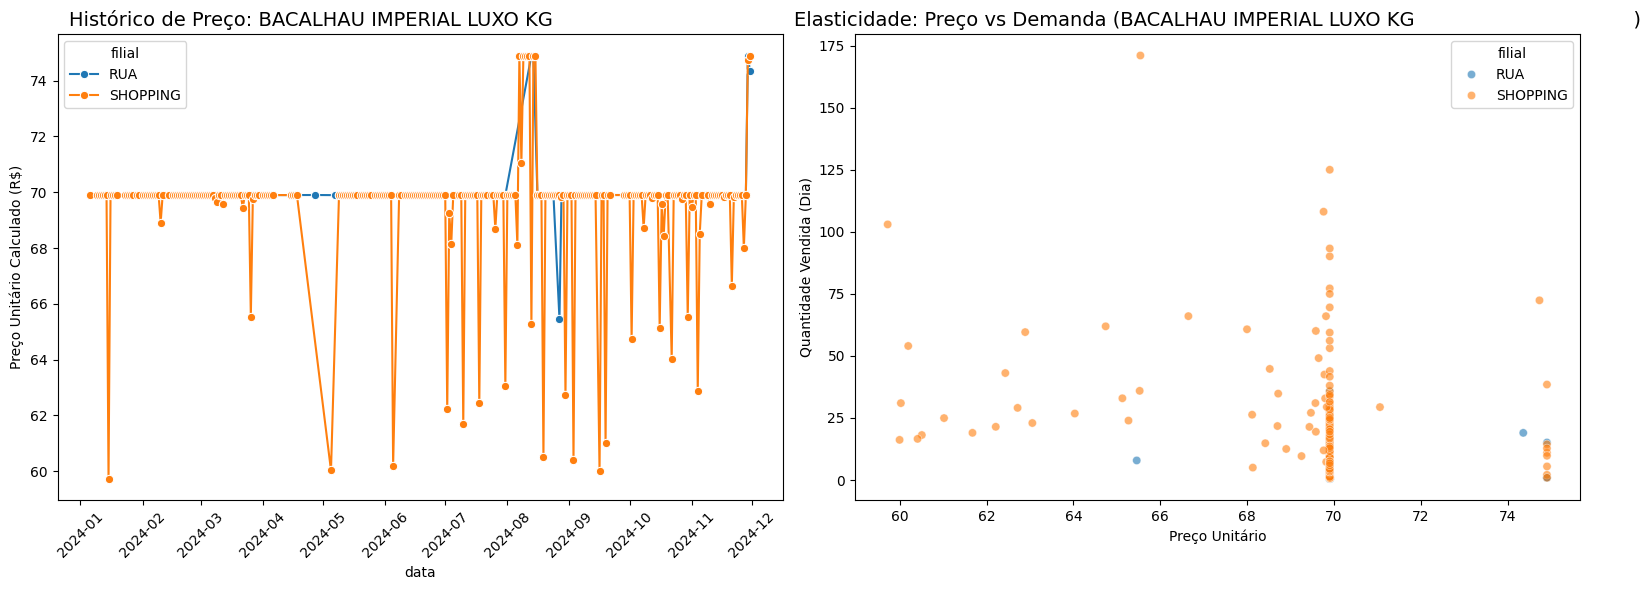

--- Tabela Pareto (Top 5 Produtos) ---


,NOME_PRODUTO,faturamento,% Acumulado,Curva
12,BACALHAU IMPERIAL LUXO KG ...,342083.50,5.381910,A
1,AMEIXA S/CAROCO EXTRA MACIA KG ...,307394.93,10.218074,A
36,LOMBO DE BACALHAU KG ...,298549.89,14.915082,A
50,PSYLLIUM FIBRA (HUSK) KG ...,265015.09,19.084495,A
24,DAMASCO DOCE GRAUDO KG ...,204057.78,22.294882,A


In [13]:
performance_produto = df_completo.groupby('NOME_PRODUTO').agg({
    'faturamento': 'sum',
    'demanda': 'sum'
}).reset_index()

# Ordenando do maior para o menor
performance_produto = performance_produto.sort_values('faturamento', ascending=False)

# Calculando a porcentagem acumulada (Pareto)
performance_produto['% Faturamento'] = (performance_produto['faturamento'] / performance_produto['faturamento'].sum()) * 100
performance_produto['% Acumulado'] = performance_produto['% Faturamento'].cumsum()

# Definindo quem é Curva A (representam 80% do faturamento)
performance_produto['Curva'] = np.where(performance_produto['% Acumulado'] <= 80, 'A', 'B/C')

# --- VISUALIZAÇÃO 1: TOP 10 PRODUTOS ---
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de Barras (Top 10 Produtos)
sns.barplot(
    data=performance_produto.head(10),
    x='faturamento',
    y='NOME_PRODUTO',
    palette='magma',
    ax=ax[0]
)
ax[0].set_title('Top 10 Produtos por Faturamento', fontsize=14)
ax[0].set_xlabel('Faturamento Total (R$)')

# Gráfico de Categorias (Quem vende mais?)
vendas_categoria = df_completo.groupby('CATEGORIA')['demanda'].sum().sort_values(ascending=False).reset_index()
sns.barplot(
    data=vendas_categoria,
    x='demanda',
    y='CATEGORIA',
    palette='viridis',
    ax=ax[1]
)
ax[1].set_title('Volume de Vendas (Demanda) por Categoria', fontsize=14)

plt.tight_layout()
plt.show()

# --- PARTE 2: ANÁLISE DE PREÇO (ENGENHARIA REVERSA) ---

# 1. Calculando o Preço Unitário Médio por transação
# Filtramos demanda > 0 para evitar divisão por zero ou infinito
df_valido = df_completo[df_completo['demanda'] > 0].copy()
df_valido['preco_unitario'] = df_valido['faturamento'] / df_valido['demanda']

# 2. Selecionando o Produto Nº 1 (O Campeão de Vendas) para análise detalhada
top_produto = performance_produto.iloc[0]['NOME_PRODUTO']
df_top_prod = df_valido[df_valido['NOME_PRODUTO'] == top_produto]

# --- VISUALIZAÇÃO 2: DINÂMICA DE PREÇO ---
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Evolução do Preço ao Longo do Tempo (Houve inflação ou promoção?)
sns.lineplot(data=df_top_prod, x='data', y='preco_unitario', hue='filial', marker='o', ax=ax[0])
ax[0].set_title(f'Histórico de Preço: {top_produto}', fontsize=14)
ax[0].set_ylabel('Preço Unitário Calculado (R$)')
ax[0].tick_params(axis='x', rotation=45)

# Elasticidade (Preço vs Demanda) - O preço baixo aumenta a venda?
sns.scatterplot(data=df_top_prod, x='preco_unitario', y='demanda', hue='filial', alpha=0.6, ax=ax[1])
ax[1].set_title(f'Elasticidade: Preço vs Demanda ({top_produto})', fontsize=14)
ax[1].set_xlabel('Preço Unitário')
ax[1].set_ylabel('Quantidade Vendida (Dia)')

plt.tight_layout()
plt.show()

# Exibindo a tabela Pareto resumida
print("--- Tabela Pareto (Top 5 Produtos) ---")
display(performance_produto[['NOME_PRODUTO', 'faturamento', '% Acumulado', 'Curva']].head())

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# --- 1. PREPARAÇÃO E LIMPEZA ---

# Criando uma cópia para não alterar o original
df_ml = df_completo.copy()

# A. Removendo Redundância e Colunas de "Futuro" (Data Leakage)
# Removemos 'faturamento', 'num_transacoes', etc, pois não teremos isso no dia da previsão
cols_to_drop = ['NOME_PRODUTO', 'faturamento', 'num_transacoes', 'clientes_unicos']
df_ml = df_ml.drop(columns=cols_to_drop, errors='ignore')

# B. Tratando Valores Nulos (Prevenção)
# Se o produto não tinha categoria, preenchemos com "OUTROS" para não dar erro no Encoder
cols_texto = ['CATEGORIA', 'SUBCATEGORIA', 'filial', 'unidade']
df_ml[cols_texto] = df_ml[cols_texto].fillna('DESCONHECIDO')

# C. Label Encoding (Transformando Texto em Número)
# Guardaremos os encoders caso precisemos inverter depois
encoders = {}

for col in cols_texto:
    le = LabelEncoder()
    df_ml[col] = le.fit_transform(df_ml[col].astype(str))
    encoders[col] = le
    print(f"Coluna '{col}' codificada. Classes: {len(le.classes_)}")

# --- 2. DIVISÃO DE TREINO E VALIDAÇÃO (TIME SERIES SPLIT) ---
# ATENÇÃO: Em séries temporais, NÃO podemos usar shuffle (embaralhar).
# Vamos treinar com Jan-Out e validar com Novembro (para simular a previsão de Dezembro)

data_corte = '2024-11-01'
features = [c for c in df_ml.columns if c not in ['data', 'demanda']] # Tudo menos data e target
target = 'demanda'

X_train = df_ml[df_ml['data'] < data_corte][features]
y_train = df_ml[df_ml['data'] < data_corte][target]

X_val = df_ml[df_ml['data'] >= data_corte][features]
y_val = df_ml[df_ml['data'] >= data_corte][target]

print(f"\nLinhas Treino: {X_train.shape[0]}")
print(f"Linhas Validação (Novembro): {X_val.shape[0]}")

Coluna 'CATEGORIA' codificada. Classes: 13
Coluna 'SUBCATEGORIA' codificada. Classes: 23
Coluna 'filial' codificada. Classes: 2
Coluna 'unidade' codificada. Classes: 2

Linhas Treino: 24926
Linhas Validação (Novembro): 2653



--- 🤖 Treinando Gradient Boosting ---
Tempo GB: 4.74s
RMSE Gradient Boosting: 6.2030

--- ⚡ Treinando LightGBM ---
Tempo LightGBM: 0.27s
RMSE LightGBM: 6.2011

🏆 VENCEDOR: LightGBM (Melhor por 0.0019 pontos)


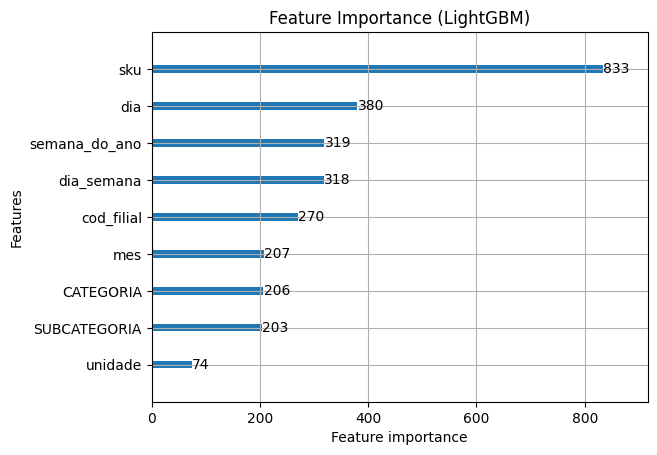

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import time

# --- MODELO A: GRADIENT BOOSTING (Sklearn) ---
print("\n--- 🤖 Treinando Gradient Boosting ---")
start = time.time()

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train, y_train)

gb_pred = gb_model.predict(X_val)
# Correção básica: Demanda não pode ser negativa
gb_pred = np.maximum(gb_pred, 0)

gb_rmse = np.sqrt(mean_squared_error(y_val, gb_pred))
print(f"Tempo GB: {time.time() - start:.2f}s")
print(f"RMSE Gradient Boosting: {gb_rmse:.4f}")

# --- MODELO B: LIGHTGBM ---
print("\n--- ⚡ Treinando LightGBM ---")
start = time.time()

# O LGBM lida muito bem com categóricas se avisarmos ele
# Vamos converter explicitamente as colunas categóricas para o tipo 'category' do Pandas (opcional, mas bom)
# Mas aqui usaremos o dataset numérico que já criamos.

lgbm_model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbose=-1
)
lgbm_model.fit(X_train, y_train)

lgbm_pred = lgbm_model.predict(X_val)
lgbm_pred = np.maximum(lgbm_pred, 0)

lgbm_rmse = np.sqrt(mean_squared_error(y_val, lgbm_pred))
print(f"Tempo LightGBM: {time.time() - start:.2f}s")
print(f"RMSE LightGBM: {lgbm_rmse:.4f}")

# --- CONCLUSÃO ---
print("\n" + "="*30)
if lgbm_rmse < gb_rmse:
    print(f"🏆 VENCEDOR: LightGBM (Melhor por {gb_rmse - lgbm_rmse:.4f} pontos)")
else:
    print(f"🏆 VENCEDOR: Gradient Boosting (Melhor por {lgbm_rmse - gb_rmse:.4f} pontos)")
print("="*30)

# Verificando a importância das variáveis (no vencedor LightGBM)
lgb.plot_importance(lgbm_model, max_num_features=10, title='Feature Importance (LightGBM)')
plt.show()

In [22]:

df_sub = pd.read_csv('data/sample_submission.csv') # Seu template

print(f"Linhas no Teste: {df_test.shape[0]}")

# --- 2. ENGENHARIA DE FEATURES (REPETINDO O PROCESSO DO TREINO) ---

# A. Merge com Produto (Para pegar Categoria e Subcategoria)
# Garantindo tipo numérico no SKU para o merge funcionar
df_produto['SKU'] = pd.to_numeric(df_produto['SKU'], errors='coerce')
df_test_completo = pd.merge(
    df_test,
    df_produto,
    left_on='sku',
    right_on='SKU',
    how='left'
)
# Removendo coluna duplicada do merge
df_test_completo.drop('SKU', axis=1, inplace=True, errors='ignore')

# B. Transformação de Data
df_test_completo['data'] = pd.to_datetime(df_test_completo['data'])

# Criando as mesmas colunas que usamos no treino
df_test_completo['dia'] = df_test_completo['data'].dt.day
df_test_completo['mes'] = df_test_completo['data'].dt.month
df_test_completo['ano'] = df_test_completo['data'].dt.year
df_test_completo['dia_semana'] = df_test_completo['data'].dt.dayofweek
df_test_completo['semana_do_ano'] = df_test_completo['data'].dt.isocalendar().week.astype(int)
df_test_completo['is_fim_de_semana'] = df_test_completo['dia_semana'].isin([5, 6]).astype(int)

# --- 3. PREPARAÇÃO PARA O MODELO ---

# A. Tratando Nulos nas Categorias (Igual ao treino)
cols_texto = ['CATEGORIA', 'SUBCATEGORIA', 'filial', 'unidade']
df_test_completo[cols_texto] = df_test_completo[cols_texto].fillna('DESCONHECIDO')

# B. Aplicando os Encoders (TRANSFORM)
# IMPORTANTE: Não usamos fit_transform aqui, apenas transform!
# Usamos o dicionário 'encoders' que criamos na etapa de treino
for col in cols_texto:
    if col in encoders:
        # Truque para evitar erro se aparecer uma categoria nova que não existia no treino
        # Se aparecer algo novo, transformamos em 'DESCONHECIDO' ou usamos um valor padrão
        df_test_completo[col] = df_test_completo[col].map(
            lambda x: encoders[col].transform([x])[0] if x in encoders[col].classes_ else -1
        )
    else:
        print(f"Aviso: Encoder para {col} não encontrado.")

# C. Selecionando as Colunas (Garantindo a mesma ordem do treino)
# Pegamos as colunas usadas no X_train
cols_modelo = X_train.columns.tolist()
X_test = df_test_completo[cols_modelo]

# --- 4. PREVISÃO E GERAÇÃO DO ARQUIVO ---

# Escolha o seu melhor modelo (Ex: lgbm_model ou gb_model)
# Aqui estou usando o lgbm_model como exemplo
predicoes = lgbm_model.predict(X_test)

# Garantindo que não haja vendas negativas
predicoes = np.maximum(predicoes, 0)

# Preenchendo o template de submissão
df_sub['demanda'] = predicoes

# Salvando o arquivo final
nome_arquivo = 'submissao_final_v1.csv'
df_sub.to_csv(nome_arquivo, index=False)

print(f"\n✅ Arquivo '{nome_arquivo}' gerado com sucesso!")
print("As primeiras 5 linhas da sua submissão:")
display(df_sub.head())

Linhas no Teste: 2753

✅ Arquivo 'submissao_final_v1.csv' gerado com sucesso!
As primeiras 5 linhas da sua submissão:


,id,demanda
0,0,2.640121
1,1,2.727715
2,2,2.710675
3,3,2.718703
4,4,2.684372


In [23]:
import pandas as pd
import numpy as np

# --- 2. FEATURE ENGINEERING (REPETINDO A LÓGICA DO TREINO) ---

# A. Merge com Produto
# Convertendo SKU para numérico para garantir o match
df_produto['SKU'] = pd.to_numeric(df_produto['SKU'], errors='coerce')
df_test_completo = pd.merge(
    df_test,
    df_produto,
    left_on='sku',
    right_on='SKU',
    how='left'
)
df_test_completo.drop('SKU', axis=1, inplace=True, errors='ignore')

# B. Transformação de Data
df_test_completo['data'] = pd.to_datetime(df_test_completo['data'])

# Criando as colunas de calendário (VITAL: Mesmos nomes do treino)
df_test_completo['dia'] = df_test_completo['data'].dt.day
df_test_completo['mes'] = df_test_completo['data'].dt.month
df_test_completo['ano'] = df_test_completo['data'].dt.year
df_test_completo['dia_semana'] = df_test_completo['data'].dt.dayofweek
df_test_completo['semana_do_ano'] = df_test_completo['data'].dt.isocalendar().week.astype(int)
df_test_completo['is_fim_de_semana'] = df_test_completo['dia_semana'].isin([5, 6]).astype(int)

# --- 3. CODIFICAÇÃO (ENCODING) ---

# A. Tratando Nulos nas Categorias
cols_texto = ['CATEGORIA', 'SUBCATEGORIA', 'filial', 'unidade']
# Verificando quais dessas colunas realmente existem no dataframe de teste
cols_existentes = [c for c in cols_texto if c in df_test_completo.columns]
df_test_completo[cols_existentes] = df_test_completo[cols_existentes].fillna('DESCONHECIDO')

# B. Aplicando os Encoders TREINADOS ANTERIORMENTE
# Nota: Usamos o dicionário 'encoders' que foi criado na etapa de treino
for col in cols_existentes:
    if col in encoders:
        # Lógica segura: Se aparecer uma categoria nova, usa -1 (ou trata como erro)
        # O LabelEncoder padrão do sklearn quebra com valores novos, então usamos map
        df_test_completo[col] = df_test_completo[col].map(
            lambda x: encoders[col].transform([x])[0] if x in encoders[col].classes_ else -1
        )
    else:
        print(f"⚠️ Aviso: Encoder para '{col}' não encontrado na memória.")

# --- 4. SELEÇÃO DE COLUNAS ---

# A ordem das colunas no Teste TEM que ser igual à ordem do Treino
# Usamos X_train.columns para garantir essa ordem
cols_modelo = X_train.columns.tolist()
X_test = df_test_completo[cols_modelo]

print(f"\nFeatures usadas: {X_test.columns.tolist()}")

# --- 5. PREVISÃO COM GRADIENT BOOSTING ---

print("\nRealizando previsões com Gradient Boosting...")
# Usando o modelo gb_model treinado anteriormente
gb_pred = gb_model.predict(X_test)

# Tratamento pós-processamento: Vendas não podem ser negativas
gb_pred = np.maximum(gb_pred, 0)

# --- 6. SALVANDO O ARQUIVO ---

df_sub['demanda'] = gb_pred
nome_arquivo_gb = 'submissao_gradient_boosting.csv'
df_sub.to_csv(nome_arquivo_gb, index=False)

print(f"\n✅ Arquivo '{nome_arquivo_gb}' gerado com sucesso!")
display(df_sub.head())


Features usadas: ['sku', 'cod_filial', 'filial', 'unidade', 'CATEGORIA', 'SUBCATEGORIA', 'dia', 'mes', 'ano', 'dia_semana', 'semana_do_ano', 'is_fim_de_semana']

Realizando previsões com Gradient Boosting...

✅ Arquivo 'submissao_gradient_boosting.csv' gerado com sucesso!


,id,demanda
0,0,2.637481
1,1,2.624700
2,2,2.676729
3,3,2.666723
4,4,2.614317



⚡ Iniciando treinamento com LightGBM...
Gerando previsões...

✅ Arquivo 'submissao_lgbm_feriados.csv' gerado com sucesso!

O que o LightGBM aprendeu?


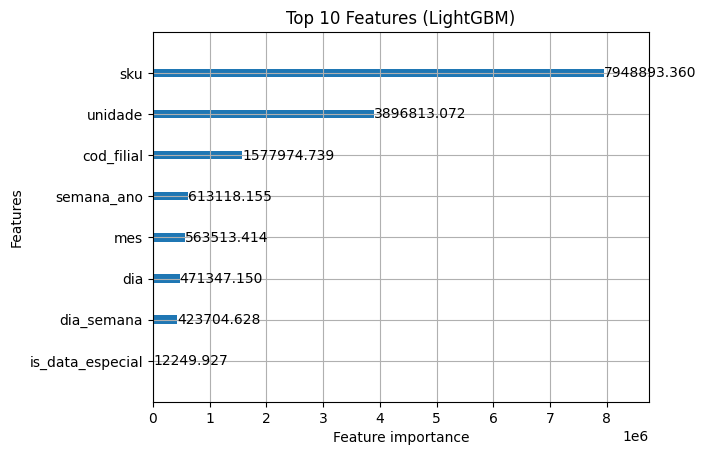

In [33]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Garantindo tipos numéricos para o merge correto
df_produto['SKU'] = pd.to_numeric(df_produto['SKU'], errors='coerce')

# Merge (Left Join)
df_train_full = pd.merge(df_train, df_produto, left_on='sku', right_on='SKU', how='left')
df_test_full = pd.merge(df_test, df_produto, left_on='sku', right_on='SKU', how='left')

# Convertendo datas
df_train_full['data'] = pd.to_datetime(df_train_full['data'])
df_test_full['data'] = pd.to_datetime(df_test_full['data'])

# --- 2. ENGENHARIA DE FEATURES (A ESTRATÉGIA "FERIADOS") ---

def criar_features_lgbm(df):
    df = df.copy()

    # Calendário Básico
    df['dia'] = df['data'].dt.day
    df['mes'] = df['data'].dt.month
    df['dia_semana'] = df['data'].dt.dayofweek
    df['semana_ano'] = df['data'].dt.isocalendar().week.astype(int)
    df['is_fim_de_semana'] = df['dia_semana'].isin([5, 6]).astype(int)

    # --- FEATURES DE NEGÓCIO (FERIADOS) ---
    feriados_varejo = [
        '2024-02-12', '2024-02-13', # Carnaval
        '2024-03-31', # Páscoa
        '2024-05-12', # Dia das Mães
        '2024-06-12', # Namorados
        '2024-08-11', # Pais
        '2024-10-12', # Crianças
        '2024-11-29', # Black Friday
        '2024-12-24', '2024-12-25', # Natal
        '2024-12-31'  # Ano Novo
    ]
    df['is_data_especial'] = df['data'].isin(pd.to_datetime(feriados_varejo)).astype(int)

    # Feature "Reta Final de Dezembro"
    df['is_natal_period'] = ((df['mes'] == 12) & (df['dia'] >= 20) & (df['dia'] <= 25)).astype(int)

    return df

df_train_proc = criar_features_lgbm(df_train_full)
df_test_proc = criar_features_lgbm(df_test_full)

# --- 3. CODIFICAÇÃO PARA LGBM ---

# Removemos categorias de texto, focamos nas IDs
cols_cat = ['filial', 'unidade']


encoders = {}
# Encoding
for col in cols_cat:
    le = LabelEncoder()
    df_train_proc[col] = le.fit_transform(df_train_proc[col].astype(str))
    # Map seguro para o teste
    df_test_proc[col] = df_test_proc[col].map(
        lambda x: le.transform([str(x)])[0] if str(x) in le.classes_ else -1
    )

# Definindo Features e Target
# SKU entra como feature numérica. O LGBM lida bem com isso.
features = [
    'sku', 'cod_filial', 'filial', 'unidade',
    'dia', 'mes', 'dia_semana', 'semana_ano', 'is_fim_de_semana',
    'is_data_especial', 'is_natal_period'
]
target = 'demanda'

X = df_train_proc[features]
y = df_train_proc[target]
X_test = df_test_proc[features]

# --- 4. TREINAMENTO (LIGHTGBM) ---

print("\n⚡ Iniciando treinamento com LightGBM...")

# Configuração Otimizada do Modelo
model_lgbm = lgb.LGBMRegressor(
    objective='regression',  # Poderia ser 'poisson' para contagem, mas regression é mais estável
    n_estimators=500,        # LGBM é rápido, podemos usar mais árvores
    learning_rate=0.05,      # Taxa de aprendizado mais suave
    num_leaves=31,           # Complexidade da árvore (padrão é 31)
    max_depth=-1,            # Deixa a árvore crescer (limitado pelas folhas)
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Avisando ao modelo quais colunas são categóricas (Melhora a performance)
# 'filial' e 'unidad' são categóricas. 'sku' deixamos como numérico contínuo.
categorical_feats = ['filial', 'unidade']

model_lgbm.fit(
    X, y,
    categorical_feature=categorical_feats,
)

# --- 5. PREVISÃO E EXPORTAÇÃO ---

print("Gerando previsões...")
predicoes = model_lgbm.predict(X_test)

# Tratamento: Sem vendas negativas
predicoes = np.maximum(predicoes, 0)

# Salvando
df_sub['demanda'] = predicoes
arquivo_saida = 'submissao_lgbm_feriados.csv'
df_sub.to_csv(arquivo_saida, index=False)

print(f"\n✅ Arquivo '{arquivo_saida}' gerado com sucesso!")

# --- 6. ANÁLISE DE IMPORTÂNCIA ---
print("\nO que o LightGBM aprendeu?")
lgb.plot_importance(model_lgbm, max_num_features=10, title='Top 10 Features (LightGBM)', importance_type='gain')
plt.show()